# Loading libraries

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action = 'ignore',
                      category = FutureWarning)

# Functions

## Confusion matrix plot

In [2]:
def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title = 'Confusion Matrix',
                          cmap = plt.cm.Blues):
    
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting 'normalize = True'
    """

    plt.imshow(cm,
               interpolation = 'nearest',
               cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float')/cm.sum(axis = 1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print("Confusion matrix, without normalization")
    
    print(cm)
    
    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment = 'center',
                 color = "white" if cm[i , j] > thresh else "black")
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')



# Preparing data

In [3]:
train_path = '/Users/matthieukhairallah/Documents/Deep Learning Tutorial/dogs-vs-cats/train'
test_path = "/Users/matthieukhairallah/Documents/Deep Learning Tutorial/dogs-vs-cats/test"
valid_path = "/Users/matthieukhairallah/Documents/Deep Learning Tutorial/dogs-vs-cats/valid"

In [4]:
train_batches = ImageDataGenerator(preprocessing_function = tf.keras.applications.vgg16.preprocess_input)\
    .flow_from_directory(directory = train_path, #specifying the directory path
                         target_size = (224, 224), #height and width we want the image to be resized to
                         classes = ['cat', 'dog'], #specifying our classes for our labels
                         batch_size = 10)

valid_batches = ImageDataGenerator(preprocessing_function = tf.keras.applications.vgg16.preprocess_input)\
    .flow_from_directory(directory = valid_path,
                         target_size = (224, 224),
                         classes = ['cat', 'dog'],
                         batch_size = 10)

test_batches = ImageDataGenerator(preprocessing_function = tf.keras.applications.vgg16.preprocess_input)\
    .flow_from_directory(directory = test_path,
                         target_size = (224, 224),
                         classes = ['cat', 'dog'],
                         batch_size = 10,
                         shuffle = False)


Found 1000 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


# Loading & training VGG-16 model

In [5]:
vgg_16_model = tf.keras.applications.vgg16.VGG16()

2023-11-03 22:33:08.673629: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2023-11-03 22:33:08.673657: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2023-11-03 22:33:08.673665: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2023-11-03 22:33:08.673734: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-11-03 22:33:08.673896: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [6]:
vgg_16_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [7]:
model = Sequential()
for layer in vgg_16_model.layers[:-1]:
    model.add(layer)

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

In [9]:
for layer in model.layers:
    layer.trainable = False

In [10]:
model.add(Dense(units = 2,
                activation = 'softmax'))

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

## Training the model

In [12]:
model.compile(optimizer = Adam(learning_rate = 0.0001),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

In [13]:
model.fit(x = train_batches,
          validation_data = valid_batches,
          epochs = 5,
          verbose = 2)

2023-11-03 22:33:13.801204: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Epoch 1/5


2023-11-03 22:33:13.848287: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-11-03 22:33:14.321793: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-03 22:33:36.523690: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-11-03 22:33:36.770386: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


100/100 - 28s - loss: 3.4621 - accuracy: 0.8120 - val_loss: 0.5621 - val_accuracy: 0.9300 - 28s/epoch - 283ms/step
Epoch 2/5
100/100 - 20s - loss: 0.5862 - accuracy: 0.9420 - val_loss: 0.5557 - val_accuracy: 0.9300 - 20s/epoch - 202ms/step
Epoch 3/5
100/100 - 20s - loss: 0.4522 - accuracy: 0.9570 - val_loss: 0.9132 - val_accuracy: 0.9200 - 20s/epoch - 201ms/step
Epoch 4/5
100/100 - 22s - loss: 0.3466 - accuracy: 0.9590 - val_loss: 0.4026 - val_accuracy: 0.9600 - 22s/epoch - 216ms/step
Epoch 5/5
100/100 - 22s - loss: 0.2829 - accuracy: 0.9650 - val_loss: 0.2717 - val_accuracy: 0.9750 - 22s/epoch - 224ms/step


## Model predictions

In [14]:
predictions = model.predict(x = test_batches,
                            verbose = 0)


2023-11-03 22:35:06.640218: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-11-03 22:35:06.777360: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [15]:
test_batches.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [16]:
cm = confusion_matrix(y_true = test_batches.classes,
                      y_pred = np.argmax(predictions,
                                         axis = -1))

In [17]:
test_batches.class_indices

{'cat': 0, 'dog': 1}

Confusion matrix, without normalization
[[49  1]
 [ 4 46]]


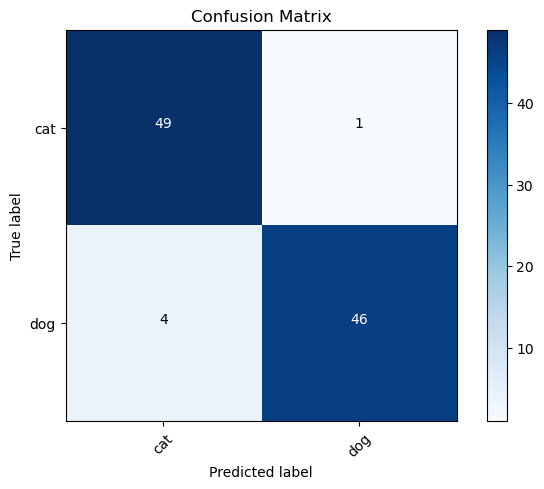

In [18]:
cm_plot_labels = ['cat', 'dog']
plot_confusion_matrix(cm = cm,
                      classes = cm_plot_labels,
                      title = 'Confusion Matrix')